A Deep Learning Toy Model for Image Compression
===

In this project, we will use simple deep learning networks for basic image compression.

You will get familiar with:

* train/test a simple deep learning model (for image compression in this project) with PyTorch library 
* hyper-parameter tuning for deep learning model
* collect and analyse the training loss and metrics
* evaluate and visualize the result

## 1. Objectives
1. Train a baseline neural network.
2. plot the loss-epoch curve.
3. Tune learning rate, the depth of the network, and different layers. Then compare the results in SSIM, PSNR.
4. visualize some cases.
5. Customize your model (and loss, learning rate, scheduler, etc) for better performance.


## Get GPU ready

Change Runtime Type in the Colab menu to 'GPU'.

## Prepare the data

The data for training/test is at https://drive.google.com/drive/folders/1--iDlKbCuD4bYmSXUj7CrP-u4EezqGyv?usp=sharing

1. Put this folder (and the data inside of course) in your GoogleDrive.
2. Run the command below to mount the GoogleDrive onto Colab.
3. Check the path to the data (e.g. `'/content/drive/MyDrive/MYDATA'`), and we will use this later.

Hint: you can check the file with either bash command or use the leftmost sidebar in Colab, there's a folder shaped icon.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check the data: When you do `!ls YOUR_DATA_PATH`, you should see `train` and `valid` under the dir.

## 1.1 Code Template

*Excute this part and see if we could use GPU.

Let's firt import packages for this project. You are not required to make modifications to this. But if you are using any other packages that's not included, feel free to import anytime.

In [ ]:
# ################################################
# import packages

import argparse
import math
import random
import shutil
import sys

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms


from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset


Check if using GPU:

In [ ]:
print(torch.cuda.is_available()) # check if cuda is avaliable so that we could use GPU

True


Then we define a Dataset class that could iterate over images under a directory (`root/split`). 

You are not required to make modifications to this.

In [ ]:
# ################################################
# define our Dataset class

class ImageFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
                - img000.png
                - img001.png
                ...
            - valid/
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
        split (string): split mode ('train' or 'val')
    """

    def __init__(self, root, transform=None, split="train"):
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)


Then let's define a baseline neural network.

In [ ]:
# ###################################################
# a baseline model

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}


Let's check if this network structure works fine with data flow.

In [ ]:
# 1. get some random data
data = torch.zeros((1, 3, 128, 128))
# 2. get a random instance of the model class
model = Network(5, 5)
# 3. forward the data to the model
preds = model(data)
# 4. do compress
compressed = model.compress(data)
# 5. decompress
data_hat = model.decompress(compressed)

If there's no error pops out in the last code cell, then our network is fine.

We can compute the compression ratio of this network

In [ ]:
print('compression ratio: compressed/original {}'.format(compressed.numel() / data.numel()))

compression ratio: compressed/original 0.006510416666666667


The compression ratio of this random network is suprising, but we don't expect any good performance as the model is too small. 

Usually the larger the model, the better the performance given sufficient training data and iterations.

Let's move on to the loss, average meter, and optimizer. 

A good thing about this task is we don't need extra label but the input image.

The loss is simply compared between the decoded image and the original one.

In [ ]:
class Loss(nn.Module):

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        out = {}
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["loss"] = out["mse_loss"] * 255

        return out

In [ ]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def configure_optimizers(net, learning_rate):

    optimizer = optim.Adam(
        net.parameters(),
        lr=learning_rate,
    )

    return optimizer

In [ ]:
def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")

After we almost got everything we need, we define a `train_one_epoch` function for training the model for one epoch.

In [ ]:
def train_one_epoch(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f}'
            )


Likewise we further define a `test_epoch` function for getting the error on a valid set. 

This part of data is not used in the training process, and will only be used to check the performance and give us implications of the performance of the model on unseen data.

This function returns the average loss on the valid split data.

In [ ]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f}\n"
    )

    return loss.avg

Finally we define a main function, and complete the whole training/testing process.

At the start of this main function, we define some arguments that's useful for training.

In [ ]:
!ls drive/MyDrive/ELEC5306-2022

train  valid  Video


Define some arguments useful for training/validation.

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
dataset = '/content/drive/MyDrive/ELEC5306-2022'  # path to the root of the dataset
checkpoint = ''                                   # load pretrained model
epochs = 10                                       # total training epochs
num_workers = 3                          # multi-process for loading training data
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-4  
batch_size = 16
test_batch_size = 16 
N = 128
M = 192

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="valid", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda"),
)

net = Network(N, M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")
for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Learning rate: 0.0001
Train epoch 0: [0/250 (0%)]	Loss: 4574.635 |	MSE loss: 17.940
Train epoch 0: [160/250 (62%)]	Loss: 159.240 |	MSE loss: 0.624
Test epoch 0: Average losses:	Loss: 98.455 |	MSE loss: 0.386

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 101.057 |	MSE loss: 0.396
Train epoch 1: [160/250 (62%)]	Loss: 35.001 |	MSE loss: 0.137
Test epoch 1: Average losses:	Loss: 50.361 |	MSE loss: 0.197

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 46.063 |	MSE loss: 0.181
Train epoch 2: [160/250 (62%)]	Loss: 37.982 |	MSE loss: 0.149
Test epoch 2: Average losses:	Loss: 32.560 |	MSE loss: 0.128

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 24.773 |	MSE loss: 0.097
Train epoch 3: [160/250 (62%)]	Loss: 15.148 |	MSE loss: 0.059
Test epoch 3: Average losses:	Loss: 23.199 |	MSE loss: 0.091

Learning rate: 0.0001
Train epoch 4: [0/250 (0%)]	Loss: 22.510 |	MSE loss: 0.088
Train epoch 4: [160/250 (62%)]	Loss: 11.861 |	MSE loss: 0.047
Test epoch 4: Average losses:	Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'compressed-decoded')

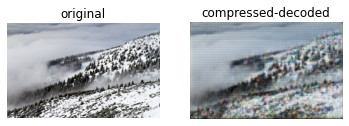

In [ ]:
# visualization
import matplotlib.pyplot as plt

dataset = '/content/drive/MyDrive/ELEC5306-2022'
test_dataset = ImageFolder(dataset, split="valid", transform=transforms.ToTensor())
image = test_dataset[1].unsqueeze(0).to(device)
net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted = net(image)['x_hat'].squeeze(0).detach()

fig, axes = plt.subplots(1,2)
axes[0].imshow(image.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

## 1.2 PSNR as AverageMeter for testing


A scratch example of PSNR, no gaurantee for working.

Free to grab online.




In [ ]:
def PSNR(img1, img2):
    # img1 and img2 within range [0, 1]
    img1, img2 = img1.detach(), img2.detach()
    img1 = img1 * 255
    img2 = img2 * 255
    batch_size = img1.shape[0]
    img1 = img1.reshape(batch_size, -1)
    img2 = img2.reshape(batch_size, -1)
    mse = torch.mean((img1 - img2) ** 2)
    return torch.mean(20 * torch.log10(255.0 / torch.sqrt(mse)))


A scratch example of SSIM, details are at https://github.com/VainF/pytorch-msssim

In [ ]:
!pip install pytorch-msssim

In [ ]:
import torch
from pytorch_msssim import ssim

# X: (N,3,H,W) a batch of non-negative RGB images (0~1)
# Y: (N,3,H,W)  

X = torch.randn((2, 3, 10, 10))
Y = torch.randn((2, 3, 10, 10))

X = X * 255
Y = Y * 255

# calculate ssim & ms-ssim for each image
ssim_val = ssim(X, Y, data_range=255, size_average=False) # return (N,)
print(ssim_val)
print(type(ssim_val))


tensor([ 0.0767, -0.0258])
<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/pytorch_msssim/ssim.py:51: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([2, 3, 10, 10]) and win size: 11
  f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"
/usr/local/lib/python3.7/dist-packages/pytorch_msssim/ssim.py:51: UserWarning: Skipping Gaussian Smoothing at dimension 2+1 for input: torch.Size([2, 3, 10, 10]) and win size: 11
  f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"



Your code here:

In [ ]:
# class Loss(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.mse = nn.MSELoss()

#     def forward(self, output, target):
#         out = {}
#         out["mse_loss"] = self.mse(output["x_hat"], target)
#         out["loss"] = out["mse_loss"] * 255

#         return out

In [ ]:
# class AverageMeter:
#     """Compute running average."""

#     def __init__(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0

#     def update(self, val, n=1):
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count

In [ ]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    psnr = AverageMeter()
    myssim = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            
            # calculate the PSNR and SSIM
            psnr.update(PSNR(d_out, d))
            ssim_val = ssim(d * 255, d_out * 255, data_range=255, size_average=True)
            # print(ssim_val)
            myssim.update(ssim_val)
            

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        # print out the PSNR and SSIM value
        f"\tPSNR value: {psnr.avg:.3f} |"
        f"\tSSIM value: {myssim.avg:.3f}\n"
    )

    return loss.avg

# do the test on valid split

As we already have the DataLoaders, here we just train our network again. At the same time, do the test on valid set (in test_dataloader). All those four values (Loss, MSE, PSNR and SSIM are printed directly after each epoch)

In [ ]:
net = Network(N, M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")
for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )

Learning rate: 0.0001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 2981.080 |	MSE loss: 11.691
Train epoch 0: [160/250 (62%)]	Loss: 132.255 |	MSE loss: 0.519
Test epoch 0: Average losses:	Loss: 91.622 |	MSE loss: 0.359 |	PSNR value: 4.500 |	SSIM value: 0.008

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 71.134 |	MSE loss: 0.279
Train epoch 1: [160/250 (62%)]	Loss: 54.083 |	MSE loss: 0.212
Test epoch 1: Average losses:	Loss: 48.288 |	MSE loss: 0.189 |	PSNR value: 7.264 |	SSIM value: 0.020

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 66.579 |	MSE loss: 0.261
Train epoch 2: [160/250 (62%)]	Loss: 43.151 |	MSE loss: 0.169
Test epoch 2: Average losses:	Loss: 31.762 |	MSE loss: 0.125 |	PSNR value: 9.082 |	SSIM value: 0.034

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 17.500 |	MSE loss: 0.069
Train epoch 3: [160/250 (62%)]	Loss: 28.672 |	MSE loss: 0.112
Test epoch 3: Average losses:	Loss: 23.374 |	MSE loss: 0.092 |	PSNR value: 10.417 |	SSIM value: 0.049

Learning rate: 0.0001
Train epoch 4: 

## 1.3 Loss-Epoch curve


A naive exmaple, no gaurantee for work.

In [ ]:
# loss_epoch = list()

# for epoch in range(last_epoch, epochs):
#     print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
#     train_one_epoch(
#         net,
#         criterion,
#         train_dataloader,
#         optimizer,
#         epoch,
#         clip_max_norm,
#     )
#     loss = test_epoch(epoch, test_dataloader, net, criterion)
#     #
#     loss_epoch.append(loss)
#     #
#     lr_scheduler.step(loss)

#     is_best = loss < best_loss
#     best_loss = min(loss, best_loss)

# assert last_epoch == 0
# xs = range(1, epochs+1)
# ys = loss_epoch
# # do plot
# plt(xs,ys)


Your code here:

Firstly we re-train the network and set up a list named "loss_epoch" to store the loss values after each epoch

In [ ]:
net = Network(N, M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )



Learning rate: 0.0001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 3438.916 |	MSE loss: 13.486
Train epoch 0: [160/250 (62%)]	Loss: 90.525 |	MSE loss: 0.355
Test epoch 0: Average losses:	Loss: 99.272 |	MSE loss: 0.389 |	PSNR value: 4.172 |	SSIM value: 0.008

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 79.037 |	MSE loss: 0.310
Train epoch 1: [160/250 (62%)]	Loss: 50.365 |	MSE loss: 0.198
Test epoch 1: Average losses:	Loss: 60.266 |	MSE loss: 0.236 |	PSNR value: 6.294 |	SSIM value: 0.016

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 47.434 |	MSE loss: 0.186
Train epoch 2: [160/250 (62%)]	Loss: 43.290 |	MSE loss: 0.170
Test epoch 2: Average losses:	Loss: 39.009 |	MSE loss: 0.153 |	PSNR value: 8.188 |	SSIM value: 0.027

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 35.542 |	MSE loss: 0.139
Train epoch 3: [160/250 (62%)]	Loss: 31.858 |	MSE loss: 0.125
Test epoch 3: Average losses:	Loss: 26.206 |	MSE loss: 0.103 |	PSNR value: 9.919 |	SSIM value: 0.043

Learning rate: 0.0001
Train epoch 4: [0

The epoch numbers (from 1 to 10) is our x-axis, the corresponding loss values is our y-axis.

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
ys = loss_epoch
# do plot
print(xs)
print(type(xs))
print(ys)
print(type(ys))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
<class 'list'>
[tensor(99.2718, device='cuda:0'), tensor(60.2663, device='cuda:0'), tensor(39.0088, device='cuda:0'), tensor(26.2057, device='cuda:0'), tensor(16.7448, device='cuda:0'), tensor(11.9871, device='cuda:0'), tensor(10.0123, device='cuda:0'), tensor(7.9297, device='cuda:0'), tensor(8.1846, device='cuda:0'), tensor(6.6140, device='cuda:0')]
<class 'list'>


Before we plot the values, we have to change the data type in the ys (which contains the loss values) from tensor to float.

In [ ]:
myys = ys.copy()
for i in range(0,len(myys)):
  myys[i] = myys[i].cpu().item()

print(myys)
print(type(myys))

[99.27183532714844, 60.266326904296875, 39.00881576538086, 26.205739974975586, 16.744815826416016, 11.987064361572266, 10.012341499328613, 7.92966365814209, 8.184591293334961, 6.614010810852051]
<class 'list'>


Then plot the figure: Epochs vs Loss

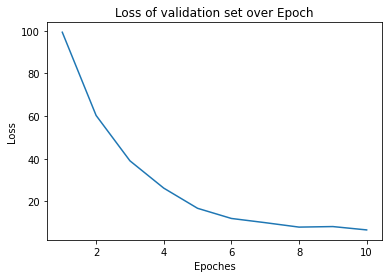

In [ ]:
plt.figure()
plt.title('Loss of validation set over Epoch')
plt.plot(xs,myys)
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.show()

## 1.4 Tune hyper-parameters

In this part, we re-define 3 networks with different (N,M) which is the 

### 1.4.1 (N, M): (32, 48)

#### 1.4.1.1 Re-define the Network and other parameters

In [ ]:
class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
dataset = '/content/drive/MyDrive/ELEC5306-2022'  # path to the root of the dataset
checkpoint = ''                                   # load pretrained model
epochs = 30                                       # total training epochs
num_workers = 3                          # multi-process for loading training data
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
# learning_rate = 1e-4  
batch_size = 16
test_batch_size = 16 
N = 32
M = 48

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="valid", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda"),
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### 1.4.1.2 Re-define the test-epoch function so that it will also return the value for MSE, PSNR, SSIM.

In [ ]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    psnr = AverageMeter()
    myssim = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            
            psnr.update(PSNR(d_out, d))
            ssim_val = ssim(d * 255, d_out * 255, data_range=255, size_average=True)
            # print(ssim_val)
            myssim.update(ssim_val)
            

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        f"\tPSNR value: {psnr.avg:.3f} |"
        f"\tSSIM value: {myssim.avg:.3f}\n"
    )

    return loss.avg, mse_loss.avg, psnr.avg, myssim.avg

# do the test on valid split

#### 1.4.1.3 When learning rate = 1e-3

In [ ]:
learning_rate = 1e-3
combine_loss = []
combine_mse = []
combine_psnr = []
combine_ssim = []
net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
MSE_epoch = [] # set up a list to store the MSE value after each epoch
PSNR_epoch = [] # set up a list to store the PSNR value after each epoch
ssim_epoch = [] # set up a list to store the SSIM value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch.append(mse_avg)
    PSNR_epoch.append(psnr_avg)
    ssim_epoch.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 0.001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 1368.125 |	MSE loss: 5.365
Train epoch 0: [160/250 (62%)]	Loss: 57.789 |	MSE loss: 0.227
Test epoch 0: Average losses:	Loss: 30.138 |	MSE loss: 0.118 |	PSNR value: 9.283 |	SSIM value: 0.024

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 29.626 |	MSE loss: 0.116
Train epoch 1: [160/250 (62%)]	Loss: 12.509 |	MSE loss: 0.049
Test epoch 1: Average losses:	Loss: 12.945 |	MSE loss: 0.051 |	PSNR value: 12.976 |	SSIM value: 0.092

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 7.842 |	MSE loss: 0.031
Train epoch 2: [160/250 (62%)]	Loss: 11.089 |	MSE loss: 0.043
Test epoch 2: Average losses:	Loss: 11.627 |	MSE loss: 0.046 |	PSNR value: 13.448 |	SSIM value: 0.103

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 7.564 |	MSE loss: 0.030
Train epoch 3: [160/250 (62%)]	Loss: 17.530 |	MSE loss: 0.069
Test epoch 3: Average losses:	Loss: 22.629 |	MSE loss: 0.089 |	PSNR value: 10.566 |	SSIM value: 0.093

Learning rate: 0.001
Train epoch 4: [0/250

#### 1.4.1.4 When learning rate = 1e-4

In [ ]:
def save_checkpoint2(state, is_best, filename="checkpoint2.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss2.pth.tar")

In [ ]:
learning_rate = 1e-4

net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch2 = [] # set up a list to store the loss value after each epoch
MSE_epoch2 = [] # set up a list to store the loss value after each epoch
PSNR_epoch2 = [] # set up a list to store the loss value after each epoch
ssim_epoch2 = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch2.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch2.append(mse_avg)
    PSNR_epoch2.append(psnr_avg)
    ssim_epoch2.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint2(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 0.0001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 575.382 |	MSE loss: 2.256
Train epoch 0: [160/250 (62%)]	Loss: 89.388 |	MSE loss: 0.351
Test epoch 0: Average losses:	Loss: 95.718 |	MSE loss: 0.375 |	PSNR value: 4.265 |	SSIM value: 0.005

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 89.705 |	MSE loss: 0.352
Train epoch 1: [160/250 (62%)]	Loss: 64.066 |	MSE loss: 0.251
Test epoch 1: Average losses:	Loss: 53.345 |	MSE loss: 0.209 |	PSNR value: 6.808 |	SSIM value: 0.015

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 38.652 |	MSE loss: 0.152
Train epoch 2: [160/250 (62%)]	Loss: 25.846 |	MSE loss: 0.101
Test epoch 2: Average losses:	Loss: 30.203 |	MSE loss: 0.118 |	PSNR value: 9.291 |	SSIM value: 0.027

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 24.817 |	MSE loss: 0.097
Train epoch 3: [160/250 (62%)]	Loss: 13.957 |	MSE loss: 0.055
Test epoch 3: Average losses:	Loss: 20.643 |	MSE loss: 0.081 |	PSNR value: 10.955 |	SSIM value: 0.051

Learning rate: 0.0001
Train epoch 4: [0/

#### 1.4.1.5 When learning rate = 1e-5

In [ ]:
def save_checkpoint3(state, is_best, filename="checkpoint3.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss3.pth.tar")

In [ ]:
learning_rate = 1e-5

net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch3 = [] # set up a list to store the loss value after each epoch
MSE_epoch3 = [] # set up a list to store the loss value after each epoch
PSNR_epoch3 = [] # set up a list to store the loss value after each epoch
ssim_epoch3 = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch3.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch3.append(mse_avg)
    PSNR_epoch3.append(psnr_avg)
    ssim_epoch3.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint3(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 1e-05


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 1113.887 |	MSE loss: 4.368
Train epoch 0: [160/250 (62%)]	Loss: 835.329 |	MSE loss: 3.276
Test epoch 0: Average losses:	Loss: 549.616 |	MSE loss: 2.155 |	PSNR value: -3.332 |	SSIM value: 0.000

Learning rate: 1e-05
Train epoch 1: [0/250 (0%)]	Loss: 442.228 |	MSE loss: 1.734
Train epoch 1: [160/250 (62%)]	Loss: 340.548 |	MSE loss: 1.335
Test epoch 1: Average losses:	Loss: 338.400 |	MSE loss: 1.327 |	PSNR value: -1.225 |	SSIM value: 0.000

Learning rate: 1e-05
Train epoch 2: [0/250 (0%)]	Loss: 277.769 |	MSE loss: 1.089
Train epoch 2: [160/250 (62%)]	Loss: 227.906 |	MSE loss: 0.894
Test epoch 2: Average losses:	Loss: 229.630 |	MSE loss: 0.901 |	PSNR value: 0.462 |	SSIM value: 0.000

Learning rate: 1e-05
Train epoch 3: [0/250 (0%)]	Loss: 210.732 |	MSE loss: 0.826
Train epoch 3: [160/250 (62%)]	Loss: 162.293 |	MSE loss: 0.636
Test epoch 3: Average losses:	Loss: 172.959 |	MSE loss: 0.678 |	PSNR value: 1.696 |	SSIM value: 0.000

Learning rate: 1e-05
Train epo

#### 1.4.1.6 Combine all the results for different learning rates

In [ ]:

combine_loss = [loss_epoch,loss_epoch2,loss_epoch3]

combine_mse = [MSE_epoch,MSE_epoch2,MSE_epoch3]

combine_psnr = [PSNR_epoch,PSNR_epoch2,PSNR_epoch3]

combine_ssim = [ssim_epoch,ssim_epoch2,ssim_epoch3]

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
print(xs)
print(type(xs))
print(loss_epoch)
print(type(loss_epoch))

for i in range(0,len(loss_epoch)):
  loss_epoch[i] = loss_epoch[i].cpu().item()

print(loss_epoch)
print(type(loss_epoch))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
<class 'list'>
[tensor(30.1376, device='cuda:0'), tensor(12.9447, device='cuda:0'), tensor(11.6268, device='cuda:0'), tensor(22.6287, device='cuda:0'), tensor(9.2793, device='cuda:0'), tensor(6.4353, device='cuda:0'), tensor(6.1676, device='cuda:0'), tensor(4.6969, device='cuda:0'), tensor(4.7473, device='cuda:0'), tensor(3.6421, device='cuda:0'), tensor(3.5687, device='cuda:0'), tensor(3.1811, device='cuda:0'), tensor(3.1572, device='cuda:0'), tensor(2.3284, device='cuda:0'), tensor(2.3710, device='cuda:0'), tensor(3.0700, device='cuda:0'), tensor(4.8709, device='cuda:0'), tensor(2.8460, device='cuda:0'), tensor(2.2822, device='cuda:0'), tensor(2.1996, device='cuda:0'), tensor(2.0013, device='cuda:0'), tensor(2.1125, device='cuda:0'), tensor(1.8352, device='cuda:0'), tensor(2.3343, device='cuda:0'), tensor(1.6608, device='cuda:0'), tensor(1.6468, device='cuda:0'), tensor(1.4

In [ ]:
for i in range(0,len(loss_epoch2)):
  loss_epoch2[i] = loss_epoch2[i].cpu().item()

for i in range(0,len(loss_epoch3)):
  loss_epoch3[i] = loss_epoch3[i].cpu().item()

for i in range(0,len(MSE_epoch)):
  MSE_epoch[i] = MSE_epoch[i].cpu().item()
print(MSE_epoch)
print(type(MSE_epoch))

for i in range(0,len(MSE_epoch2)):
  MSE_epoch2[i] = MSE_epoch2[i].cpu().item()

for i in range(0,len(MSE_epoch3)):
  MSE_epoch3[i] = MSE_epoch3[i].cpu().item()

for i in range(0,len(PSNR_epoch)):
  PSNR_epoch[i] = PSNR_epoch[i].cpu().item()
print(PSNR_epoch)
print(type(PSNR_epoch))

for i in range(0,len(PSNR_epoch2)):
  PSNR_epoch2[i] = PSNR_epoch2[i].cpu().item()

for i in range(0,len(PSNR_epoch3)):
  PSNR_epoch3[i] = PSNR_epoch3[i].cpu().item()


[0.11818667501211166, 0.050763390958309174, 0.04559525102376938, 0.08874013274908066, 0.03638960048556328, 0.025236666202545166, 0.024186698719859123, 0.01841932162642479, 0.018616843968629837, 0.01428276114165783, 0.013994865119457245, 0.012474961578845978, 0.012381195090711117, 0.009130915626883507, 0.009298132732510567, 0.012039350345730782, 0.01910146325826645, 0.011160971596837044, 0.008949973620474339, 0.008625919930636883, 0.007848253473639488, 0.00828438252210617, 0.00719667412340641, 0.009154272265732288, 0.006513088010251522, 0.0064581334590911865, 0.005783814005553722, 0.006990125402808189, 0.00631323829293251, 0.0064565702341496944]
<class 'list'>
[9.283283233642578, 12.975863456726074, 13.447761535644531, 10.565749168395996, 14.394208908081055, 16.04964256286621, 16.17264175415039, 17.38468360900879, 17.350358963012695, 18.478261947631836, 18.58368492126465, 19.06418228149414, 19.081802368164062, 20.465797424316406, 20.37305450439453, 19.28565788269043, 17.20183563232422, 

In [ ]:
for i in range(0,len(ssim_epoch)):
  ssim_epoch[i] = ssim_epoch[i].cpu().item()
print(ssim_epoch)
print(type(ssim_epoch))

for i in range(0,len(ssim_epoch2)):
  ssim_epoch2[i] = ssim_epoch2[i].cpu().item()

for i in range(0,len(ssim_epoch3)):
  ssim_epoch3[i] = ssim_epoch3[i].cpu().item()

[0.023697227239608765, 0.09158860146999359, 0.10336276143789291, 0.09349767863750458, 0.14853224158287048, 0.19006946682929993, 0.24258825182914734, 0.2536367177963257, 0.26955968141555786, 0.32085418701171875, 0.34656772017478943, 0.38577836751937866, 0.4247337281703949, 0.4509234130382538, 0.41564926505088806, 0.42875319719314575, 0.4487387537956238, 0.45811232924461365, 0.4777413308620453, 0.5064997673034668, 0.5106992125511169, 0.5237587690353394, 0.5374866724014282, 0.5389093160629272, 0.5568112134933472, 0.5637311339378357, 0.538942277431488, 0.4980084300041199, 0.5629961490631104, 0.5802609324455261]
<class 'list'>


#### 1.4.1.7 Print out the value of Loss, MSE, PSNR, SSIM when epoch = 0, 10, 20, 30 respectively 

In [ ]:
print("LR = 1e-3")
print(loss_epoch[0])
print(loss_epoch[9])
print(loss_epoch[19])
print(loss_epoch[29])
print("LR = 1e-4")
print(loss_epoch2[0])
print(loss_epoch2[9])
print(loss_epoch2[19])
print(loss_epoch2[29])
print("LR = 1e-5")
print(loss_epoch3[0])
print(loss_epoch3[9])
print(loss_epoch3[19])
print(loss_epoch3[29])


LR = 1e-3
30.137601852416992
3.642103910446167
2.1996095180511475
1.6464252471923828
LR = 1e-4
95.71846008300781
9.977217674255371
5.363204002380371
3.7265496253967285
LR = 1e-5
549.6160888671875
88.96602630615234
35.449554443359375
19.10933494567871


In [ ]:
print("LR = 1e-3")
print(MSE_epoch[0])
print(MSE_epoch[9])
print(MSE_epoch[19])
print(MSE_epoch[29])
print("LR = 1e-4")
print(MSE_epoch2[0])
print(MSE_epoch2[9])
print(MSE_epoch2[19])
print(MSE_epoch2[29])
print("LR = 1e-5")
print(MSE_epoch3[0])
print(MSE_epoch3[9])
print(MSE_epoch3[19])
print(MSE_epoch3[29])

LR = 1e-3
0.11818667501211166
0.01428276114165783
0.008625919930636883
0.0064565702341496944
LR = 1e-4
0.3753665089607239
0.03912634775042534
0.021032169461250305
0.014613918960094452
LR = 1e-5
2.1553571224212646
0.3488863706588745
0.13901785016059875
0.07493856549263


In [ ]:
print("LR = 1e-3")
print(PSNR_epoch[0])
print(PSNR_epoch[9])
print(PSNR_epoch[19])
print(PSNR_epoch[29])
print("LR = 1e-4")
print(PSNR_epoch2[0])
print(PSNR_epoch2[9])
print(PSNR_epoch2[19])
print(PSNR_epoch2[29])
print("LR = 1e-5")
print(PSNR_epoch3[0])
print(PSNR_epoch3[9])
print(PSNR_epoch3[19])
print(PSNR_epoch3[29])

LR = 1e-3
9.283283233642578
18.478261947631836
20.657432556152344
21.95301055908203
LR = 1e-4
4.2654266357421875
14.11274242401123
16.816129684448242
18.41132354736328
LR = 1e-5
-3.331775188446045
4.586845874786377
8.593061447143555
11.294047355651855


In [ ]:
print("LR = 1e-3")
print(ssim_epoch[0])
print(ssim_epoch[9])
print(ssim_epoch[19])
print(ssim_epoch[29])


print("LR = 1e-4")
print(ssim_epoch2[0])
print(ssim_epoch2[9])
print(ssim_epoch2[19])
print(ssim_epoch2[29])

print("LR = 1e-5")
print(ssim_epoch3[0])
print(ssim_epoch3[9])
print(ssim_epoch3[19])
print(ssim_epoch3[29])

LR = 1e-3
0.023697227239608765
0.32085418701171875
0.5064997673034668
0.5802609324455261
LR = 1e-4
0.005448970478028059
0.1267472505569458
0.21482740342617035
0.2866825461387634
LR = 1e-5
5.8095432905247435e-05
0.006698545068502426
0.022908467799425125
0.06000635027885437


#### 1.4.1.8 Plot the results for (N,M) = (32,48)

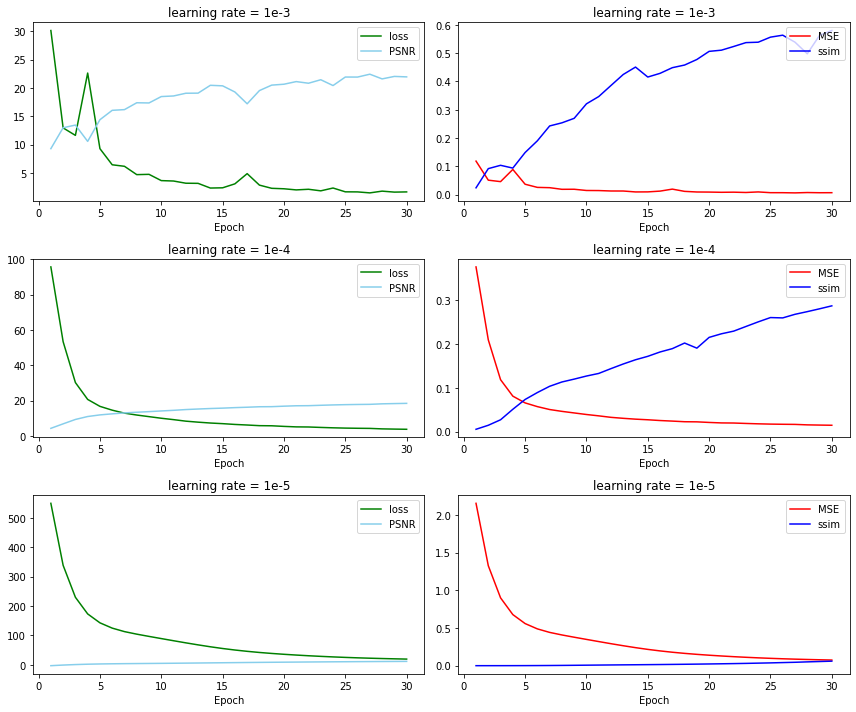

In [ ]:
import numpy as np
plt.figure
plt.figure(figsize=(12,10))
plt.subplot(3,2,1)

plt.title('learning rate = 1e-3')
plt.plot(xs, loss_epoch, color='green', label='loss')
plt.plot(xs, PSNR_epoch,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,2)
plt.title('learning rate = 1e-3')
plt.plot(xs, MSE_epoch, color='red', label='MSE')
plt.plot(xs, ssim_epoch, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')


plt.subplot(3,2,3)
plt.title('learning rate = 1e-4')
plt.plot(xs, loss_epoch2, color='green', label='loss')
plt.plot(xs, PSNR_epoch2,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,4)
plt.title('learning rate = 1e-4')
plt.plot(xs, MSE_epoch2, color='red', label='MSE')
plt.plot(xs, ssim_epoch2, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')


plt.subplot(3,2,5)
plt.title('learning rate = 1e-5')
plt.plot(xs, loss_epoch3, color='green', label='loss')
plt.plot(xs, PSNR_epoch3,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,6)
plt.title('learning rate = 1e-5')
plt.plot(xs, MSE_epoch3, color='red', label='MSE')
plt.plot(xs, ssim_epoch3, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')

plt.tight_layout()                                       

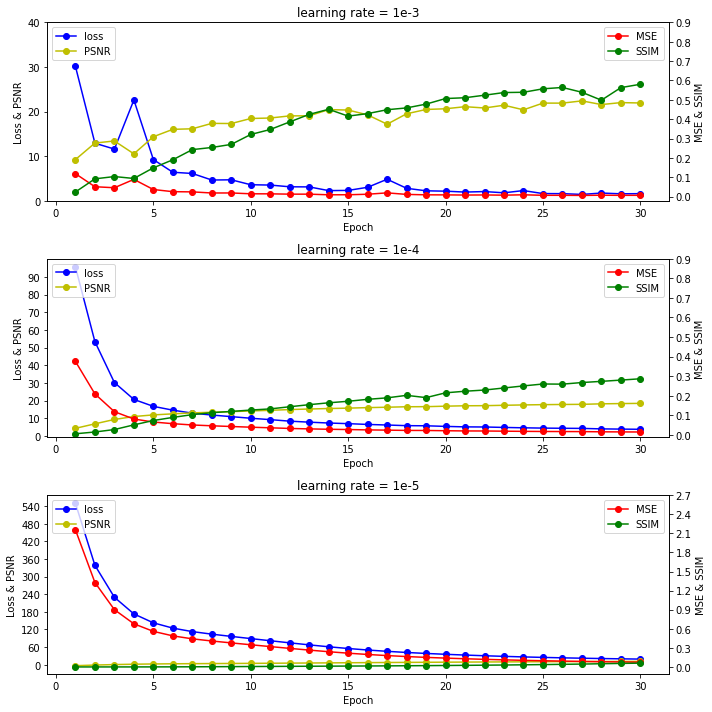

In [ ]:
plt.figure
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)

plt.title('learning rate = 1e-3')
plt.plot(xs, loss_epoch,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch,color = 'y',marker = 'o')
plt.yticks(np.arange(0,50,10))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch,color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()

plt.subplot(3,1,2)

plt.title('learning rate = 1e-4')
plt.plot(xs, loss_epoch2,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch2,color = 'y',marker = 'o')
plt.yticks(np.arange(0,100,10))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch2,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch2,color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()

plt.subplot(3,1,3)
plt.title('learning rate = 1e-5')
plt.plot(xs, loss_epoch3,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch3,color = 'y',marker = 'o')
plt.yticks(np.arange(0,600,60))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch3,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch3,color = 'g',marker = 'o')
plt.yticks(np.arange(0,3,0.3))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()

### 1.4.2 (N, M): (64, 96)

#### 1.4.2.1 Re-define the Network and other parameters

In [ ]:
class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
dataset = '/content/drive/MyDrive/ELEC5306-2022'  # path to the root of the dataset
checkpoint = ''                                   # load pretrained model
epochs = 30                                       # total training epochs
num_workers = 3                          # multi-process for loading training data
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
# learning_rate = 1e-4  
batch_size = 16
test_batch_size = 16 
N = 64
M = 96

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="valid", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda"),
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### 1.4.2.2 Re-define the test-epoch function so that it will also return the value for MSE, PSNR, SSIM.

In [ ]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    psnr = AverageMeter()
    myssim = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            
            psnr.update(PSNR(d_out, d))
            ssim_val = ssim(d * 255, d_out * 255, data_range=255, size_average=True)
            # print(ssim_val)
            myssim.update(ssim_val)
            

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        f"\tPSNR value: {psnr.avg:.3f} |"
        f"\tSSIM value: {myssim.avg:.3f}\n"
    )

    return loss.avg, mse_loss.avg, psnr.avg, myssim.avg

# do the test on valid split

#### 1.4.2.3 When learning rate = 1e-3

In [ ]:
learning_rate = 1e-3
combine_loss = []
combine_mse = []
combine_psnr = []
combine_ssim = []
net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
MSE_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch
ssim_epoch = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch.append(mse_avg)
    PSNR_epoch.append(psnr_avg)
    ssim_epoch.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 0.001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 1513.246 |	MSE loss: 5.934
Train epoch 0: [160/250 (62%)]	Loss: 99.357 |	MSE loss: 0.390
Test epoch 0: Average losses:	Loss: 45.010 |	MSE loss: 0.177 |	PSNR value: 7.562 |	SSIM value: 0.015

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 41.264 |	MSE loss: 0.162
Train epoch 1: [160/250 (62%)]	Loss: 31.004 |	MSE loss: 0.122
Test epoch 1: Average losses:	Loss: 31.401 |	MSE loss: 0.123 |	PSNR value: 9.101 |	SSIM value: 0.041

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 34.358 |	MSE loss: 0.135
Train epoch 2: [160/250 (62%)]	Loss: 21.433 |	MSE loss: 0.084
Test epoch 2: Average losses:	Loss: 23.062 |	MSE loss: 0.090 |	PSNR value: 10.450 |	SSIM value: 0.060

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 23.097 |	MSE loss: 0.091
Train epoch 3: [160/250 (62%)]	Loss: 23.352 |	MSE loss: 0.092
Test epoch 3: Average losses:	Loss: 13.767 |	MSE loss: 0.054 |	PSNR value: 12.688 |	SSIM value: 0.071

Learning rate: 0.001
Train epoch 4: [0/25

#### 1.4.2.4 When learning rate = 1e-4

In [ ]:
def save_checkpoint2(state, is_best, filename="checkpoint2.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss2.pth.tar")

In [ ]:
learning_rate = 1e-4

net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch2 = [] # set up a list to store the loss value after each epoch
MSE_epoch2 = [] # set up a list to store the loss value after each epoch
PSNR_epoch2 = [] # set up a list to store the loss value after each epoch
ssim_epoch2 = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch2.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch2.append(mse_avg)
    PSNR_epoch2.append(psnr_avg)
    ssim_epoch2.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint2(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 0.0001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 2942.731 |	MSE loss: 11.540
Train epoch 0: [160/250 (62%)]	Loss: 148.307 |	MSE loss: 0.582
Test epoch 0: Average losses:	Loss: 126.532 |	MSE loss: 0.496 |	PSNR value: 3.080 |	SSIM value: 0.004

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 130.167 |	MSE loss: 0.510
Train epoch 1: [160/250 (62%)]	Loss: 55.478 |	MSE loss: 0.218
Test epoch 1: Average losses:	Loss: 45.598 |	MSE loss: 0.179 |	PSNR value: 7.544 |	SSIM value: 0.019

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 41.958 |	MSE loss: 0.165
Train epoch 2: [160/250 (62%)]	Loss: 20.771 |	MSE loss: 0.081
Test epoch 2: Average losses:	Loss: 31.215 |	MSE loss: 0.122 |	PSNR value: 9.186 |	SSIM value: 0.036

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 32.897 |	MSE loss: 0.129
Train epoch 3: [160/250 (62%)]	Loss: 25.787 |	MSE loss: 0.101
Test epoch 3: Average losses:	Loss: 25.207 |	MSE loss: 0.099 |	PSNR value: 10.108 |	SSIM value: 0.049

Learning rate: 0.0001
Train epoch 4

#### 1.4.2.5 When learning rate = 1e-5

In [ ]:
def save_checkpoint3(state, is_best, filename="checkpoint3.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss3.pth.tar")

In [ ]:
learning_rate = 1e-5

net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch3 = [] # set up a list to store the loss value after each epoch
MSE_epoch3 = [] # set up a list to store the loss value after each epoch
PSNR_epoch3 = [] # set up a list to store the loss value after each epoch
ssim_epoch3 = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch3.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch3.append(mse_avg)
    PSNR_epoch3.append(psnr_avg)
    ssim_epoch3.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint3(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 1e-05


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 2925.478 |	MSE loss: 11.472
Train epoch 0: [160/250 (62%)]	Loss: 1338.755 |	MSE loss: 5.250
Test epoch 0: Average losses:	Loss: 933.554 |	MSE loss: 3.661 |	PSNR value: -5.628 |	SSIM value: 0.000

Learning rate: 1e-05
Train epoch 1: [0/250 (0%)]	Loss: 894.387 |	MSE loss: 3.507
Train epoch 1: [160/250 (62%)]	Loss: 409.755 |	MSE loss: 1.607
Test epoch 1: Average losses:	Loss: 373.398 |	MSE loss: 1.464 |	PSNR value: -1.648 |	SSIM value: 0.001

Learning rate: 1e-05
Train epoch 2: [0/250 (0%)]	Loss: 360.222 |	MSE loss: 1.413
Train epoch 2: [160/250 (62%)]	Loss: 208.440 |	MSE loss: 0.817
Test epoch 2: Average losses:	Loss: 206.059 |	MSE loss: 0.808 |	PSNR value: 0.944 |	SSIM value: 0.002

Learning rate: 1e-05
Train epoch 3: [0/250 (0%)]	Loss: 208.884 |	MSE loss: 0.819
Train epoch 3: [160/250 (62%)]	Loss: 151.385 |	MSE loss: 0.594
Test epoch 3: Average losses:	Loss: 144.681 |	MSE loss: 0.567 |	PSNR value: 2.488 |	SSIM value: 0.003

Learning rate: 1e-05
Train e

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train epoch 20: [160/250 (62%)]	Loss: 18.717 |	MSE loss: 0.073


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test epoch 20: Average losses:	Loss: 20.017 |	MSE loss: 0.078 |	PSNR value: 11.099 |	SSIM value: 0.064

Learning rate: 1e-05
Train epoch 21: [0/250 (0%)]	Loss: 25.286 |	MSE loss: 0.099


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train epoch 21: [160/250 (62%)]	Loss: 12.513 |	MSE loss: 0.049
Test epoch 21: Average losses:	Loss: 18.961 |	MSE loss: 0.074 |	PSNR value: 11.333 |	SSIM value: 0.067

Learning rate: 1e-05
Train epoch 22: [0/250 (0%)]	Loss: 12.776 |	MSE loss: 0.050


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train epoch 22: [160/250 (62%)]	Loss: 13.178 |	MSE loss: 0.052
Test epoch 22: Average losses:	Loss: 18.066 |	MSE loss: 0.071 |	PSNR value: 11.541 |	SSIM value: 0.070

Learning rate: 1e-05


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1f0efbf5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Train epoch 23: [0/250 (0%)]	Loss: 14.468 |	MSE loss: 0.057
Train epoch 23: [160/250 (62%)]	Loss: 19.478 |	MSE loss: 0.076
Test epoch 23: Average losses:	Loss: 17.373 |	MSE loss: 0.068 |	PSNR value: 11.710 |	SSIM value: 0.073

Learning rate: 1e-05
Train epoch 24: [0/250 (0%)]	Loss: 23.834 |	MSE loss: 0.093
Train epoch 24: [160/250 (62%)]	Loss: 15.310 |	MSE loss: 0.060
Test epoch 24: Average losses:	Loss: 16.621 |	MSE loss: 0.065 |	PSNR value: 11.902 |	SSIM value: 0.076

Learning rate: 1e-05
Train epoch 25: [0/250 (0%)]	Loss: 14.275 |	MSE loss: 0.056
Train epoch 25: [160/250 (62%)]	Loss: 8.759 |	MSE loss: 0.034
Test epoch 25: Average losses:	Loss: 15.998 |	MSE loss: 0.063 |	PSNR value: 12.068 |	SSIM value: 0.079

Learning rate: 1e-05
Train epoch 26: [0/250 (0%)]	Loss: 12.690 |	MSE loss: 0.050
Train epoch 26: [160/250 (62%)]	Loss: 10.919 |	MSE loss: 0.043
Test epoch 26: Average losses:	Loss: 15.373 |	MSE loss: 0.060 |	PSNR value: 12.241 |	SSIM value: 0.082

Learning rate: 1e-05
Train epo

#### 1.4.2.6 Combine all the results for different learning rates

In [ ]:

combine_loss = [loss_epoch,loss_epoch2,loss_epoch3]

combine_mse = [MSE_epoch,MSE_epoch2,MSE_epoch3]

combine_psnr = [PSNR_epoch,PSNR_epoch2,PSNR_epoch3]

combine_ssim = [ssim_epoch,ssim_epoch2,ssim_epoch3]

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
print(xs)
print(type(xs))
print(loss_epoch)
print(type(loss_epoch))

for i in range(0,len(loss_epoch)):
  loss_epoch[i] = loss_epoch[i].cpu().item()

print(loss_epoch)
print(type(loss_epoch))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
<class 'list'>
[tensor(45.0099, device='cuda:0'), tensor(31.4007, device='cuda:0'), tensor(23.0624, device='cuda:0'), tensor(13.7672, device='cuda:0'), tensor(20.5083, device='cuda:0'), tensor(5.8127, device='cuda:0'), tensor(10.8014, device='cuda:0'), tensor(7.4803, device='cuda:0'), tensor(8.5556, device='cuda:0'), tensor(5.3381, device='cuda:0'), tensor(4.5300, device='cuda:0'), tensor(7.4341, device='cuda:0'), tensor(4.2812, device='cuda:0'), tensor(5.7816, device='cuda:0'), tensor(3.9711, device='cuda:0'), tensor(3.0827, device='cuda:0'), tensor(2.7934, device='cuda:0'), tensor(2.9334, device='cuda:0'), tensor(2.7390, device='cuda:0'), tensor(2.2267, device='cuda:0'), tensor(2.4491, device='cuda:0'), tensor(2.3572, device='cuda:0'), tensor(2.1657, device='cuda:0'), tensor(1.6249, device='cuda:0'), tensor(1.5722, device='cuda:0'), tensor(1.8933, device='cuda:0'), tensor(3

In [ ]:
for i in range(0,len(loss_epoch2)):
  loss_epoch2[i] = loss_epoch2[i].cpu().item()

for i in range(0,len(loss_epoch3)):
  loss_epoch3[i] = loss_epoch3[i].cpu().item()

for i in range(0,len(MSE_epoch)):
  MSE_epoch[i] = MSE_epoch[i].cpu().item()
print(MSE_epoch)
print(type(MSE_epoch))

for i in range(0,len(MSE_epoch2)):
  MSE_epoch2[i] = MSE_epoch2[i].cpu().item()

for i in range(0,len(MSE_epoch3)):
  MSE_epoch3[i] = MSE_epoch3[i].cpu().item()

for i in range(0,len(PSNR_epoch)):
  PSNR_epoch[i] = PSNR_epoch[i].cpu().item()
print(PSNR_epoch)
print(type(PSNR_epoch))

for i in range(0,len(PSNR_epoch2)):
  PSNR_epoch2[i] = PSNR_epoch2[i].cpu().item()

for i in range(0,len(PSNR_epoch3)):
  PSNR_epoch3[i] = PSNR_epoch3[i].cpu().item()


[0.17650949954986572, 0.12313982844352722, 0.09044089913368225, 0.05398917198181152, 0.08042486011981964, 0.022794775664806366, 0.04235845431685448, 0.02933468483388424, 0.033551186323165894, 0.020933736115694046, 0.017764680087566376, 0.029153358191251755, 0.016788844019174576, 0.022673100233078003, 0.015573069453239441, 0.012089031748473644, 0.01095464825630188, 0.0115036740899086, 0.010741211473941803, 0.008732328191399574, 0.009604467079043388, 0.009243857115507126, 0.008493129163980484, 0.006372240372002125, 0.006165584083646536, 0.007424620911478996, 0.012680955231189728, 0.006094921380281448, 0.009952555410563946, 0.006353326141834259]
<class 'list'>
[7.561656951904297, 9.101018905639648, 10.449617385864258, 12.688203811645508, 10.949348449707031, 16.437522888183594, 13.756561279296875, 15.338979721069336, 14.744421005249023, 16.793201446533203, 17.513530731201172, 15.391569137573242, 17.758899688720703, 16.6307373046875, 18.103181838989258, 19.198165893554688, 19.60590362548828

In [ ]:
for i in range(0,len(ssim_epoch)):
  ssim_epoch[i] = ssim_epoch[i].cpu().item()
print(ssim_epoch)
print(type(ssim_epoch))

for i in range(0,len(ssim_epoch2)):
  ssim_epoch2[i] = ssim_epoch2[i].cpu().item()

for i in range(0,len(ssim_epoch3)):
  ssim_epoch3[i] = ssim_epoch3[i].cpu().item()

[0.01471959799528122, 0.04099690541625023, 0.06025981158018112, 0.07055529952049255, 0.13726699352264404, 0.20676755905151367, 0.18355068564414978, 0.16820000112056732, 0.23445181548595428, 0.2999694049358368, 0.3310871124267578, 0.2959232032299042, 0.32964885234832764, 0.36487525701522827, 0.3968658447265625, 0.4042430520057678, 0.4236757457256317, 0.4751198887825012, 0.47802847623825073, 0.506639838218689, 0.48292550444602966, 0.39841943979263306, 0.5463771224021912, 0.562065601348877, 0.581717312335968, 0.5962836146354675, 0.5755236148834229, 0.5352895259857178, 0.5807867050170898, 0.5290794372558594]
<class 'list'>


#### 1.4.2.7 Print out the value of Loss, MSE, PSNR, SSIM when epoch = 0, 10, 20, 30 respectively 

In [ ]:
print("LR = 1e-3")
print(loss_epoch[0])
print(loss_epoch[9])
print(loss_epoch[19])
print(loss_epoch[29])
print("LR = 1e-4")
print(loss_epoch2[0])
print(loss_epoch2[9])
print(loss_epoch2[19])
print(loss_epoch2[29])
print("LR = 1e-5")
print(loss_epoch3[0])
print(loss_epoch3[9])
print(loss_epoch3[19])
print(loss_epoch3[29])


LR = 1e-3
45.009918212890625
5.338102340698242
2.226743698120117
1.6200981140136719
LR = 1e-4
126.53218841552734
8.894161224365234
3.769211769104004
2.4896481037139893
LR = 1e-5
933.5538940429688
42.86994552612305
20.937381744384766
13.894472122192383


In [ ]:
print("LR = 1e-3")
print(MSE_epoch[0])
print(MSE_epoch[9])
print(MSE_epoch[19])
print(MSE_epoch[29])
print("LR = 1e-4")
print(MSE_epoch2[0])
print(MSE_epoch2[9])
print(MSE_epoch2[19])
print(MSE_epoch2[29])
print("LR = 1e-5")
print(MSE_epoch3[0])
print(MSE_epoch3[9])
print(MSE_epoch3[19])
print(MSE_epoch3[29])

LR = 1e-3
0.17650949954986572
0.020933736115694046
0.008732328191399574
0.006353326141834259
LR = 1e-4
0.4962046146392822
0.03487906605005264
0.014781223610043526
0.009763325564563274
LR = 1e-5
3.6609954833984375
0.1681174486875534
0.08210738748311996
0.05448812246322632


In [ ]:
print("LR = 1e-3")
print(PSNR_epoch[0])
print(PSNR_epoch[9])
print(PSNR_epoch[19])
print(PSNR_epoch[29])
print("LR = 1e-4")
print(PSNR_epoch2[0])
print(PSNR_epoch2[9])
print(PSNR_epoch2[19])
print(PSNR_epoch2[29])
print("LR = 1e-5")
print(PSNR_epoch3[0])
print(PSNR_epoch3[9])
print(PSNR_epoch3[19])
print(PSNR_epoch3[29])

LR = 1e-3
7.561656951904297
16.793201446533203
20.624740600585938
22.01036834716797
LR = 1e-4
3.080413341522217
14.614852905273438
18.371936798095703
20.1689453125
LR = 1e-5
-5.62770938873291
7.8041791915893555
10.903470993041992
12.68012809753418


In [ ]:
print("LR = 1e-3")
print(ssim_epoch[0])
print(ssim_epoch[9])
print(ssim_epoch[19])
print(ssim_epoch[29])


print("LR = 1e-4")
print(ssim_epoch2[0])
print(ssim_epoch2[9])
print(ssim_epoch2[19])
print(ssim_epoch2[29])

print("LR = 1e-5")
print(ssim_epoch3[0])
print(ssim_epoch3[9])
print(ssim_epoch3[19])
print(ssim_epoch3[29])

LR = 1e-3
0.01471959799528122
0.2999694049358368
0.506639838218689
0.5290794372558594
LR = 1e-4
0.0038169417530298233
0.13060441613197327
0.2940943241119385
0.38955578207969666
LR = 1e-5
0.00016298724221996963
0.02227514237165451
0.06086909770965576
0.08848860114812851


#### 1.4.2.8 Plot the results (N, M) = (64, 96)

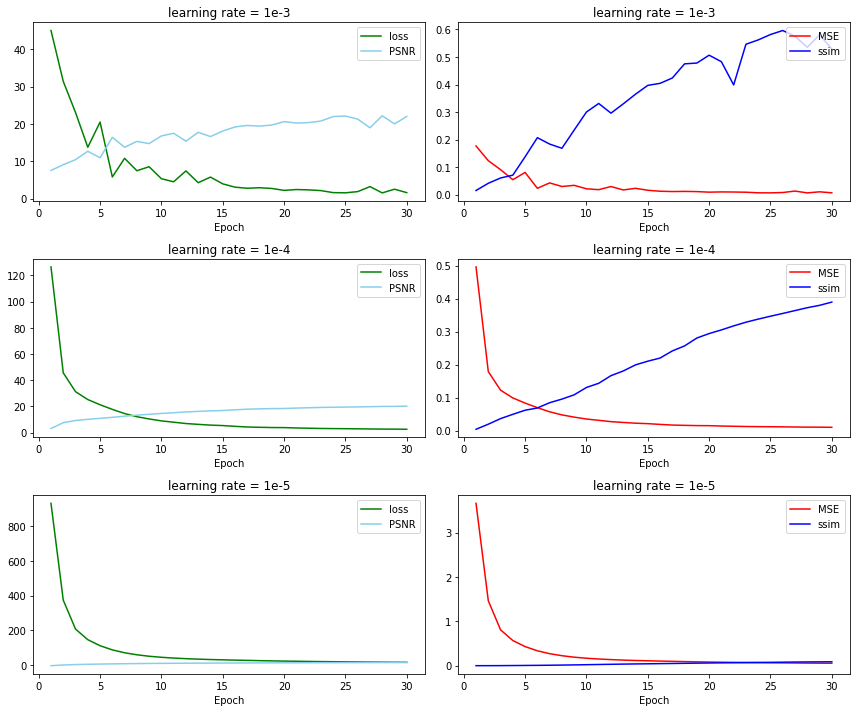

In [ ]:
import numpy as np
plt.figure
plt.figure(figsize=(12,10))
plt.subplot(3,2,1)

plt.title('learning rate = 1e-3')
plt.plot(xs, loss_epoch, color='green', label='loss')
plt.plot(xs, PSNR_epoch,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,2)
plt.title('learning rate = 1e-3')
plt.plot(xs, MSE_epoch, color='red', label='MSE')
plt.plot(xs, ssim_epoch, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')


plt.subplot(3,2,3)
plt.title('learning rate = 1e-4')
plt.plot(xs, loss_epoch2, color='green', label='loss')
plt.plot(xs, PSNR_epoch2,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,4)
plt.title('learning rate = 1e-4')
plt.plot(xs, MSE_epoch2, color='red', label='MSE')
plt.plot(xs, ssim_epoch2, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')


plt.subplot(3,2,5)
plt.title('learning rate = 1e-5')
plt.plot(xs, loss_epoch3, color='green', label='loss')
plt.plot(xs, PSNR_epoch3,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,6)
plt.title('learning rate = 1e-5')
plt.plot(xs, MSE_epoch3, color='red', label='MSE')
plt.plot(xs, ssim_epoch3, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')

plt.tight_layout()                                       

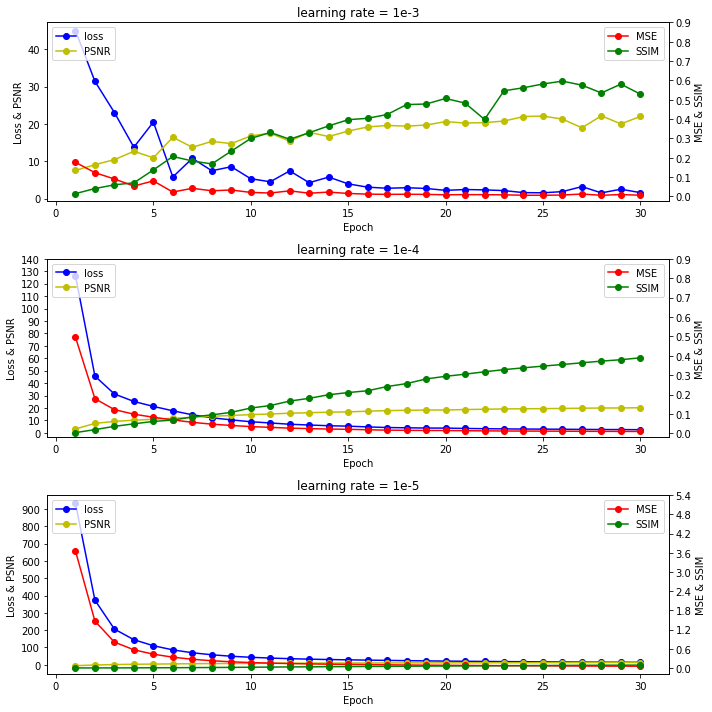

In [ ]:
plt.figure
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)

plt.title('learning rate = 1e-3')
plt.plot(xs, loss_epoch,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch,color = 'y',marker = 'o')
plt.yticks(np.arange(0,50,10))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch,color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()

plt.subplot(3,1,2)

plt.title('learning rate = 1e-4')
plt.plot(xs, loss_epoch2,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch2,color = 'y',marker = 'o')
plt.yticks(np.arange(0,150,10))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch2,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch2,color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()

plt.subplot(3,1,3)
plt.title('learning rate = 1e-5')
plt.plot(xs, loss_epoch3,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch3,color = 'y',marker = 'o')
plt.yticks(np.arange(0,1000,100))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch3,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch3,color = 'g',marker = 'o')
plt.yticks(np.arange(0,6,0.6))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()

### 1.4.3 (N, M): (128, 192)

#### 1.4.3.1 Re-define the Network and other parameters

In [ ]:
class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
dataset = '/content/drive/MyDrive/ELEC5306-2022'  # path to the root of the dataset
checkpoint = ''                                   # load pretrained model
epochs = 30                                       # total training epochs
num_workers = 3                          # multi-process for loading training data
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
# learning_rate = 1e-4  
batch_size = 16
test_batch_size = 16 
N = 128
M = 192

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="valid", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda"),
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### 1.4.3.2 Re-define the test-epoch function so that it will also return the value for MSE, PSNR, SSIM.

In [ ]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    psnr = AverageMeter()
    myssim = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            
            psnr.update(PSNR(d_out, d))
            ssim_val = ssim(d * 255, d_out * 255, data_range=255, size_average=True)
            # print(ssim_val)
            myssim.update(ssim_val)
            

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        f"\tPSNR value: {psnr.avg:.3f} |"
        f"\tSSIM value: {myssim.avg:.3f}\n"
    )

    return loss.avg, mse_loss.avg, psnr.avg, myssim.avg

# do the test on valid split

#### 1.4.3.3 When learning rate = 1e-3

In [ ]:
learning_rate = 1e-3
combine_loss = []
combine_mse = []
combine_psnr = []
combine_ssim = []
net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch = [] # set up a list to store the loss value after each epoch
MSE_epoch = [] # set up a list to store the loss value after each epoch
PSNR_epoch = [] # set up a list to store the loss value after each epoch
ssim_epoch = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch.append(mse_avg)
    PSNR_epoch.append(psnr_avg)
    ssim_epoch.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 0.001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 4574.635 |	MSE loss: 17.940
Train epoch 0: [160/250 (62%)]	Loss: 2549.381 |	MSE loss: 9.998
Test epoch 0: Average losses:	Loss: 4109.362 |	MSE loss: 16.115 |	PSNR value: -12.059 |	SSIM value: 0.000

Learning rate: 0.001
Train epoch 1: [0/250 (0%)]	Loss: 4963.037 |	MSE loss: 19.463
Train epoch 1: [160/250 (62%)]	Loss: 265.813 |	MSE loss: 1.042
Test epoch 1: Average losses:	Loss: 88.557 |	MSE loss: 0.347 |	PSNR value: 4.614 |	SSIM value: 0.007

Learning rate: 0.001
Train epoch 2: [0/250 (0%)]	Loss: 77.820 |	MSE loss: 0.305
Train epoch 2: [160/250 (62%)]	Loss: 36.237 |	MSE loss: 0.142
Test epoch 2: Average losses:	Loss: 26.256 |	MSE loss: 0.103 |	PSNR value: 9.883 |	SSIM value: 0.031

Learning rate: 0.001
Train epoch 3: [0/250 (0%)]	Loss: 25.670 |	MSE loss: 0.101
Train epoch 3: [160/250 (62%)]	Loss: 44.909 |	MSE loss: 0.176
Test epoch 3: Average losses:	Loss: 24.617 |	MSE loss: 0.097 |	PSNR value: 10.171 |	SSIM value: 0.045

Learning rate: 0.001
Train epo

#### 1.4.3.4 When learning rate = 1e-4

In [ ]:
def save_checkpoint2(state, is_best, filename="checkpoint2.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss2.pth.tar")

In [ ]:
learning_rate = 1e-4

net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch2 = [] # set up a list to store the loss value after each epoch
MSE_epoch2 = [] # set up a list to store the loss value after each epoch
PSNR_epoch2 = [] # set up a list to store the loss value after each epoch
ssim_epoch2 = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch2.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch2.append(mse_avg)
    PSNR_epoch2.append(psnr_avg)
    ssim_epoch2.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint2(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 0.0001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 4664.531 |	MSE loss: 18.292
Train epoch 0: [160/250 (62%)]	Loss: 150.067 |	MSE loss: 0.588
Test epoch 0: Average losses:	Loss: 91.949 |	MSE loss: 0.361 |	PSNR value: 4.500 |	SSIM value: 0.009

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 67.637 |	MSE loss: 0.265
Train epoch 1: [160/250 (62%)]	Loss: 56.287 |	MSE loss: 0.221
Test epoch 1: Average losses:	Loss: 45.058 |	MSE loss: 0.177 |	PSNR value: 7.581 |	SSIM value: 0.026

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 44.325 |	MSE loss: 0.174
Train epoch 2: [160/250 (62%)]	Loss: 54.146 |	MSE loss: 0.212
Test epoch 2: Average losses:	Loss: 31.813 |	MSE loss: 0.125 |	PSNR value: 9.072 |	SSIM value: 0.031

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 16.142 |	MSE loss: 0.063
Train epoch 3: [160/250 (62%)]	Loss: 22.333 |	MSE loss: 0.088
Test epoch 3: Average losses:	Loss: 22.619 |	MSE loss: 0.089 |	PSNR value: 10.557 |	SSIM value: 0.050

Learning rate: 0.0001
Train epoch 4: 

#### 1.4.3.5 When learning rate = 1e-5

In [ ]:
def save_checkpoint3(state, is_best, filename="checkpoint3.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss3.pth.tar")

In [ ]:
learning_rate = 1e-5

net = Network(N, M)
net = net.to(device)
optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")

loss_epoch3 = [] # set up a list to store the loss value after each epoch
MSE_epoch3 = [] # set up a list to store the loss value after each epoch
PSNR_epoch3 = [] # set up a list to store the loss value after each epoch
ssim_epoch3 = [] # set up a list to store the loss value after each epoch

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss, mse_avg, psnr_avg, ssim_avg = test_epoch(epoch, test_dataloader, net, criterion)

    loss_epoch3.append(loss) # save the loss value in the loss_epoch list
    MSE_epoch3.append(mse_avg)
    PSNR_epoch3.append(psnr_avg)
    ssim_epoch3.append(ssim_avg)

    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint3(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
  

Learning rate: 1e-05


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 4210.945 |	MSE loss: 16.514
Train epoch 0: [160/250 (62%)]	Loss: 900.704 |	MSE loss: 3.532
Test epoch 0: Average losses:	Loss: 542.512 |	MSE loss: 2.127 |	PSNR value: -3.266 |	SSIM value: 0.000

Learning rate: 1e-05
Train epoch 1: [0/250 (0%)]	Loss: 401.672 |	MSE loss: 1.575
Train epoch 1: [160/250 (62%)]	Loss: 231.315 |	MSE loss: 0.907
Test epoch 1: Average losses:	Loss: 249.905 |	MSE loss: 0.980 |	PSNR value: 0.130 |	SSIM value: 0.002

Learning rate: 1e-05
Train epoch 2: [0/250 (0%)]	Loss: 230.362 |	MSE loss: 0.903
Train epoch 2: [160/250 (62%)]	Loss: 153.733 |	MSE loss: 0.603
Test epoch 2: Average losses:	Loss: 157.857 |	MSE loss: 0.619 |	PSNR value: 2.150 |	SSIM value: 0.004

Learning rate: 1e-05
Train epoch 3: [0/250 (0%)]	Loss: 113.470 |	MSE loss: 0.445
Train epoch 3: [160/250 (62%)]	Loss: 110.543 |	MSE loss: 0.434
Test epoch 3: Average losses:	Loss: 110.976 |	MSE loss: 0.435 |	PSNR value: 3.691 |	SSIM value: 0.007

Learning rate: 1e-05
Train epo

#### 1.4.3.6 Combine all the results for different learning rates

In [ ]:

combine_loss = [loss_epoch,loss_epoch2,loss_epoch3]

combine_mse = [MSE_epoch,MSE_epoch2,MSE_epoch3]

combine_psnr = [PSNR_epoch,PSNR_epoch2,PSNR_epoch3]

combine_ssim = [ssim_epoch,ssim_epoch2,ssim_epoch3]

In [ ]:
from matplotlib import pyplot as plt

xs = list(range(1, epochs+1))
print(xs)
print(type(xs))
print(loss_epoch)
print(type(loss_epoch))

for i in range(0,len(loss_epoch)):
  loss_epoch[i] = loss_epoch[i].cpu().item()

print(loss_epoch)
print(type(loss_epoch))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
<class 'list'>
[tensor(4109.3623, device='cuda:0'), tensor(88.5569, device='cuda:0'), tensor(26.2564, device='cuda:0'), tensor(24.6173, device='cuda:0'), tensor(33.1517, device='cuda:0'), tensor(22.0386, device='cuda:0'), tensor(25.0176, device='cuda:0'), tensor(22.6746, device='cuda:0'), tensor(19.4979, device='cuda:0'), tensor(10.4708, device='cuda:0'), tensor(8.4997, device='cuda:0'), tensor(6.1145, device='cuda:0'), tensor(5.7641, device='cuda:0'), tensor(6.3567, device='cuda:0'), tensor(5.6037, device='cuda:0'), tensor(11.4528, device='cuda:0'), tensor(21.8240, device='cuda:0'), tensor(8.4852, device='cuda:0'), tensor(6.0765, device='cuda:0'), tensor(25.9209, device='cuda:0'), tensor(16.9804, device='cuda:0'), tensor(6.9541, device='cuda:0'), tensor(4.5334, device='cuda:0'), tensor(4.4837, device='cuda:0'), tensor(4.3315, device='cuda:0'), tensor(5.6477, device='cuda:0')

In [ ]:
for i in range(0,len(loss_epoch2)):
  loss_epoch2[i] = loss_epoch2[i].cpu().item()

for i in range(0,len(loss_epoch3)):
  loss_epoch3[i] = loss_epoch3[i].cpu().item()

for i in range(0,len(MSE_epoch)):
  MSE_epoch[i] = MSE_epoch[i].cpu().item()
print(MSE_epoch)
print(type(MSE_epoch))

for i in range(0,len(MSE_epoch2)):
  MSE_epoch2[i] = MSE_epoch2[i].cpu().item()

for i in range(0,len(MSE_epoch3)):
  MSE_epoch3[i] = MSE_epoch3[i].cpu().item()

for i in range(0,len(PSNR_epoch)):
  PSNR_epoch[i] = PSNR_epoch[i].cpu().item()
print(PSNR_epoch)
print(type(PSNR_epoch))

for i in range(0,len(PSNR_epoch2)):
  PSNR_epoch2[i] = PSNR_epoch2[i].cpu().item()

for i in range(0,len(PSNR_epoch3)):
  PSNR_epoch3[i] = PSNR_epoch3[i].cpu().item()


[16.11514663696289, 0.34728187322616577, 0.10296636819839478, 0.09653862565755844, 0.1300067901611328, 0.08642585575580597, 0.09810812771320343, 0.08891981840133667, 0.07646253705024719, 0.04106196388602257, 0.0333319827914238, 0.023978471755981445, 0.02260447107255459, 0.024928297847509384, 0.021975308656692505, 0.04491274803876877, 0.08558432757854462, 0.033275239169597626, 0.02382950857281685, 0.10165047645568848, 0.06658995151519775, 0.027271151542663574, 0.017778150737285614, 0.01758328638970852, 0.016986235976219177, 0.02214774116873741, 0.014032045379281044, 0.012987127527594566, 0.011679451912641525, 0.019074467942118645]
<class 'list'>
[-12.059290885925293, 4.614091396331787, 9.882667541503906, 10.170825958251953, 9.048341751098633, 10.648148536682129, 10.091374397277832, 10.51163387298584, 11.176569938659668, 13.898698806762695, 14.832695007324219, 16.20733642578125, 16.460582733154297, 16.065101623535156, 16.626548767089844, 13.515021324157715, 10.718515396118164, 14.8241634

In [ ]:
for i in range(0,len(ssim_epoch)):
  ssim_epoch[i] = ssim_epoch[i].cpu().item()
print(ssim_epoch)
print(type(ssim_epoch))

for i in range(0,len(ssim_epoch2)):
  ssim_epoch2[i] = ssim_epoch2[i].cpu().item()

for i in range(0,len(ssim_epoch3)):
  ssim_epoch3[i] = ssim_epoch3[i].cpu().item()

[9.096108260564506e-05, 0.006556703709065914, 0.030968284234404564, 0.04498131200671196, 0.04952123016119003, 0.07457004487514496, 0.05926582217216492, 0.07860040664672852, 0.1162293553352356, 0.19115428626537323, 0.1833643913269043, 0.1975266933441162, 0.21890902519226074, 0.2438068389892578, 0.29977867007255554, 0.2415001094341278, 0.06776658445596695, 0.1733214110136032, 0.21266119182109833, 0.22086480259895325, 0.1708606481552124, 0.22767722606658936, 0.30422699451446533, 0.3006286919116974, 0.3059436082839966, 0.2823733687400818, 0.38674646615982056, 0.36217960715293884, 0.3631802499294281, 0.35842835903167725]
<class 'list'>


#### 1.4.3.7 Print out the value of Loss, MSE, PSNR, SSIM when epoch = 0, 10, 20, 30 respectively 

In [ ]:
print("LR = 1e-3")
print(loss_epoch[0])
print(loss_epoch[9])
print(loss_epoch[19])
print(loss_epoch[29])
print("LR = 1e-4")
print(loss_epoch2[0])
print(loss_epoch2[9])
print(loss_epoch2[19])
print(loss_epoch2[29])
print("LR = 1e-5")
print(loss_epoch3[0])
print(loss_epoch3[9])
print(loss_epoch3[19])
print(loss_epoch3[29])


LR = 1e-3
4109.3623046875
10.470800399780273
25.920873641967773
4.863988876342773
LR = 1e-4
91.94894409179688
6.870845317840576
3.4101524353027344
2.2374331951141357
LR = 1e-5
542.5121459960938
40.31471252441406
19.544912338256836
12.793251037597656


In [ ]:
print("LR = 1e-3")
print(MSE_epoch[0])
print(MSE_epoch[9])
print(MSE_epoch[19])
print(MSE_epoch[29])
print("LR = 1e-4")
print(MSE_epoch2[0])
print(MSE_epoch2[9])
print(MSE_epoch2[19])
print(MSE_epoch2[29])
print("LR = 1e-5")
print(MSE_epoch3[0])
print(MSE_epoch3[9])
print(MSE_epoch3[19])
print(MSE_epoch3[29])

LR = 1e-3
16.11514663696289
0.04106196388602257
0.10165047645568848
0.019074467942118645
LR = 1e-4
0.3605841100215912
0.026944492012262344
0.013373146764934063
0.008774247951805592
LR = 1e-5
2.1274986267089844
0.15809690952301025
0.07664672285318375
0.05016961693763733


In [ ]:
print("LR = 1e-3")
print(PSNR_epoch[0])
print(PSNR_epoch[9])
print(PSNR_epoch[19])
print(PSNR_epoch[29])
print("LR = 1e-4")
print(PSNR_epoch2[0])
print(PSNR_epoch2[9])
print(PSNR_epoch2[19])
print(PSNR_epoch2[29])
print("LR = 1e-5")
print(PSNR_epoch3[0])
print(PSNR_epoch3[9])
print(PSNR_epoch3[19])
print(PSNR_epoch3[29])

LR = 1e-3
-12.059290885925293
13.898698806762695
9.944692611694336
17.216876983642578
LR = 1e-4
4.500283718109131
15.729166030883789
18.77926254272461
20.594486236572266
LR = 1e-5
-3.2656733989715576
8.06261920928955
11.192434310913086
13.0299711227417


In [ ]:
print("LR = 1e-3")
print(ssim_epoch[0])
print(ssim_epoch[9])
print(ssim_epoch[19])
print(ssim_epoch[29])


print("LR = 1e-4")
print(ssim_epoch2[0])
print(ssim_epoch2[9])
print(ssim_epoch2[19])
print(ssim_epoch2[29])

print("LR = 1e-5")
print(ssim_epoch3[0])
print(ssim_epoch3[9])
print(ssim_epoch3[19])
print(ssim_epoch3[29])

LR = 1e-3
9.096108260564506e-05
0.19115428626537323
0.22086480259895325
0.35842835903167725
LR = 1e-4
0.008921912871301174
0.16227388381958008
0.32538971304893494
0.4533328413963318
LR = 1e-5
0.00041888863779604435
0.03365769237279892
0.07150305807590485
0.10468290746212006


#### 1.4.3.8 Plot the results (N, M) = (128, 192)

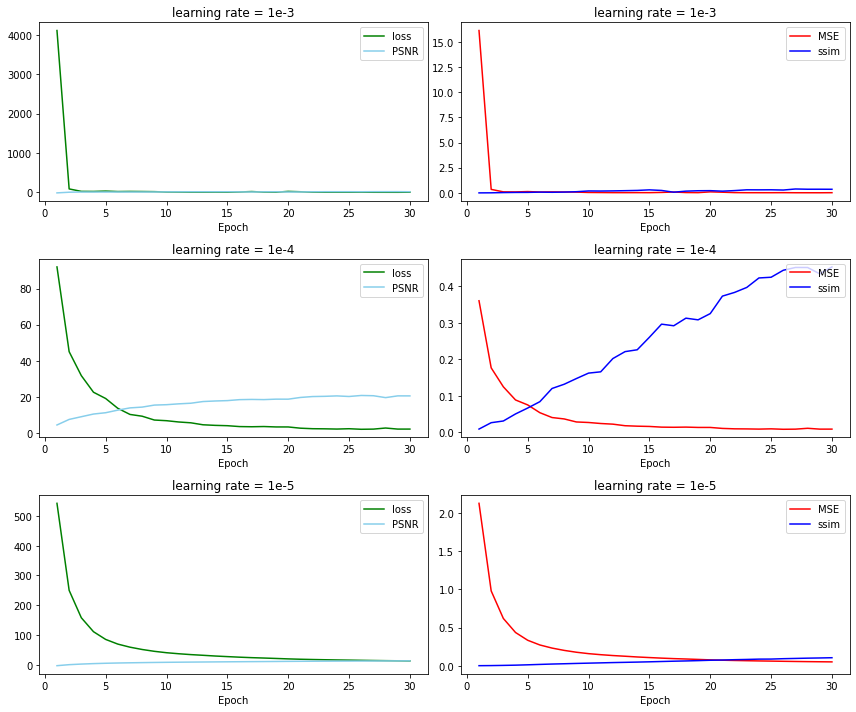

In [ ]:
import numpy as np
plt.figure
plt.figure(figsize=(12,10))
plt.subplot(3,2,1)

plt.title('learning rate = 1e-3')
plt.plot(xs, loss_epoch, color='green', label='loss')
plt.plot(xs, PSNR_epoch,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,2)
plt.title('learning rate = 1e-3')
plt.plot(xs, MSE_epoch, color='red', label='MSE')
plt.plot(xs, ssim_epoch, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')


plt.subplot(3,2,3)
plt.title('learning rate = 1e-4')
plt.plot(xs, loss_epoch2, color='green', label='loss')
plt.plot(xs, PSNR_epoch2,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,4)
plt.title('learning rate = 1e-4')
plt.plot(xs, MSE_epoch2, color='red', label='MSE')
plt.plot(xs, ssim_epoch2, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')


plt.subplot(3,2,5)
plt.title('learning rate = 1e-5')
plt.plot(xs, loss_epoch3, color='green', label='loss')
plt.plot(xs, PSNR_epoch3,  color='skyblue', label='PSNR')
plt.legend(['loss','PSNR'],loc = 'upper right')
plt.xlabel('Epoch')

plt.subplot(3,2,6)
plt.title('learning rate = 1e-5')
plt.plot(xs, MSE_epoch3, color='red', label='MSE')
plt.plot(xs, ssim_epoch3, color='blue', label='ssim')
plt.legend(['MSE','ssim'],loc = 'upper right')
plt.xlabel('Epoch')

plt.tight_layout()                                       

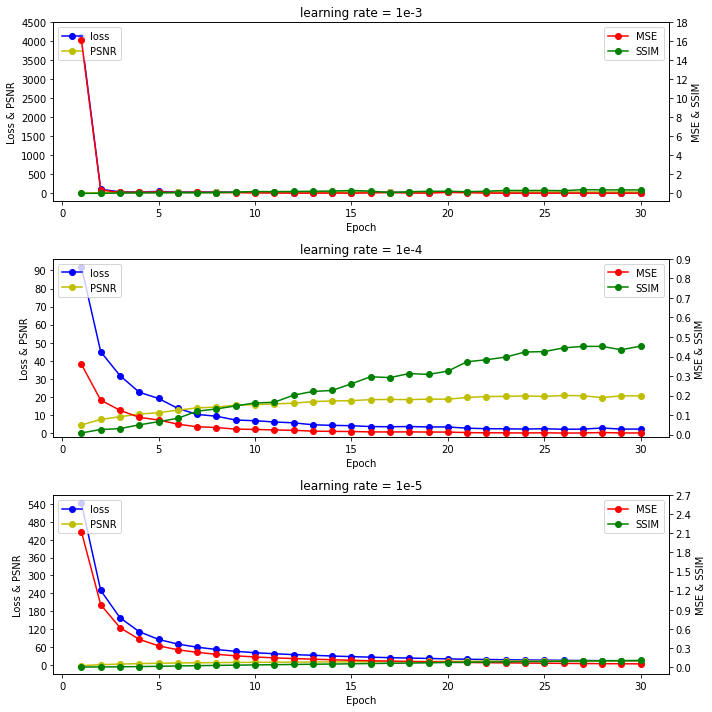

In [ ]:
plt.figure
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)

plt.title('learning rate = 1e-3')
plt.plot(xs, loss_epoch,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch,color = 'y',marker = 'o')
plt.yticks(np.arange(0,5000,500))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch,color = 'g',marker = 'o')
plt.yticks(np.arange(0,20,2))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()

plt.subplot(3,1,2)

plt.title('learning rate = 1e-4')
plt.plot(xs, loss_epoch2,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch2,color = 'y',marker = 'o')
plt.yticks(np.arange(0,100,10))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch2,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch2,color = 'g',marker = 'o')
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()

plt.subplot(3,1,3)
plt.title('learning rate = 1e-5')
plt.plot(xs, loss_epoch3,color = 'b',marker = 'o')
plt.plot(xs, PSNR_epoch3,color = 'y',marker = 'o')
plt.yticks(np.arange(0,600,60))
plt.legend(['loss','PSNR'],loc = 'upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss & PSNR')
plt.twinx()
plt.plot(xs, MSE_epoch3,color = 'r',marker = 'o')
plt.plot(xs, ssim_epoch3,color = 'g',marker = 'o')
plt.yticks(np.arange(0,3,0.3))
plt.ylabel('MSE & SSIM')
plt.legend(['MSE','SSIM'],loc = 'upper right')
plt.tight_layout()